In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import BinaryCrossEntropy
from mygrad.optimizers import SGD
from mygrad.preprocessors import MinMaxScaler, StandardScaler
from mygrad.trainers2 import BinaryClassificationTrainer, ProgressBar
from mygrad.dataloaders import NumpyRegressionDataloader

# Easy

In [5]:
train_df = pd.read_csv("../mio1/classification/easy-training.csv")
test_df = pd.read_csv("../mio1/classification/easy-test.csv")

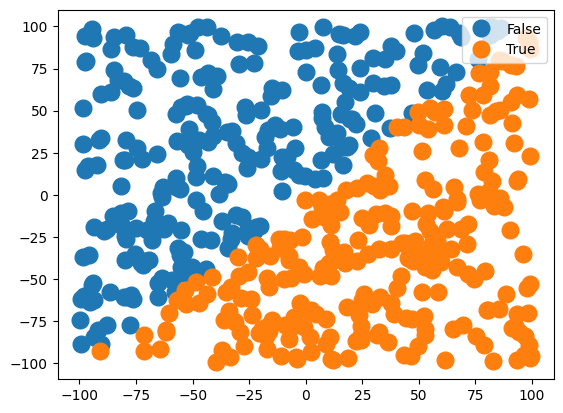

In [6]:
groups = train_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend(loc="upper right")

In [7]:
X_train = train_df[["x", "y"]].values
y_train = train_df["c"].values.reshape(-1, 1) * 1

In [8]:
X_train.shape, y_train.shape

((500, 2), (500, 1))

In [9]:
input_normalizer = StandardScaler()

X_train_scaled = input_normalizer.fit_transform(X_train)

In [10]:
model = mc.Sequential(
    mc.Linear(2, 10, init="he"),
    mc.Tanh(),
    mc.Linear(10, 1, init="he"),
    mc.Sigmoid(),
)
optimizer = SGD(model.parameters(), learning_rate=0.02, momentum=0.9, dampening=0.9)
loss = BinaryCrossEntropy()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train, batch_size=100, shuffle=True)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_outputs = trainer.train(100)

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

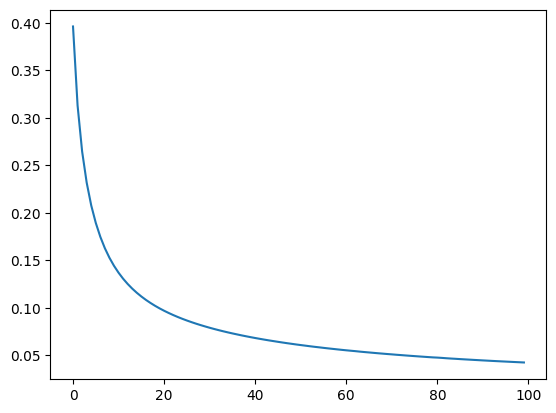

In [11]:
plt.plot(train_outputs["loss"])

In [12]:
X_test = test_df[["x", "y"]].values
y_test = test_df["c"].values.reshape(-1, 1) * 1

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = (y_pred_scaled > 0.5) * 1

print(f"F-score: {mf.fscore(y_pred, y_test, 2)}")


F-score: 0.9919999999999999
